# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


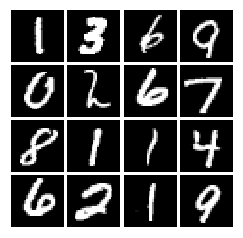

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, x*alpha)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], maxval=1, minval=-1)

Make sure noise is the correct shape and type:

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [8]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.layers.dense(x, units=256, use_bias=True, activation=leaky_relu)
        x = tf.layers.dense(x, units=256, use_bias=True, activation=leaky_relu)
        x = tf.layers.dense(x, units=1, use_bias=True)
        return x
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [9]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [10]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        z = tf.layers.dense(z, units=1024, use_bias=True, activation=tf.nn.relu)
        z = tf.layers.dense(z, units=1024, use_bias=True, activation=tf.nn.relu)
        img = tf.layers.dense(z, units=784, use_bias=True, activation=tf.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [11]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [12]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    ones = tf.ones_like(logits_fake)
    zeros = tf.zeros_like(logits_fake)
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones))
    D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [13]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [14]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [15]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [16]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

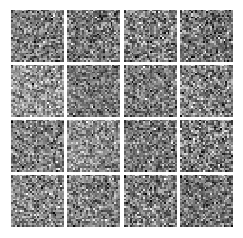


Iter: 0, D: 1.641, G:0.7569
Iter: 50, D: 1.609, G:1.75
Iter: 100, D: 1.699, G:0.8232
Iter: 150, D: 1.137, G:0.7319
Iter: 200, D: 1.561, G:1.68


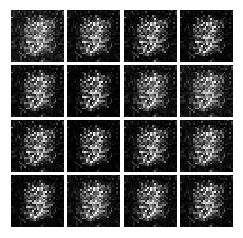


Iter: 250, D: 1.328, G:1.231
Iter: 300, D: 1.473, G:1.704
Iter: 350, D: 0.727, G:1.498
Iter: 400, D: 2.459, G:0.7682
Iter: 450, D: 1.012, G:1.449


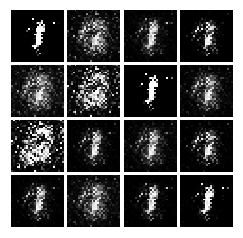


Iter: 500, D: 0.7061, G:2.102
Iter: 550, D: 0.8509, G:1.866
Iter: 600, D: 1.051, G:1.352
Iter: 650, D: 1.272, G:0.9445
Iter: 700, D: 1.149, G:2.382


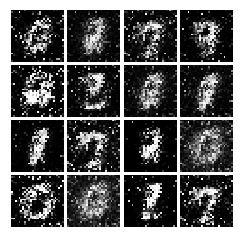


Iter: 750, D: 1.691, G:1.482
Iter: 800, D: 1.248, G:1.004
Iter: 850, D: 1.196, G:0.7168
Iter: 900, D: 1.166, G:1.03
Iter: 950, D: 1.112, G:0.8534


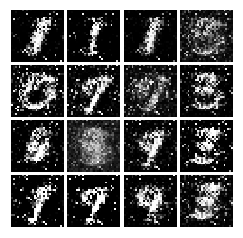


Iter: 1000, D: 1.232, G:1.21
Iter: 1050, D: 1.306, G:0.8883
Iter: 1100, D: 1.187, G:1.093
Iter: 1150, D: 1.214, G:1.07
Iter: 1200, D: 1.115, G:1.012


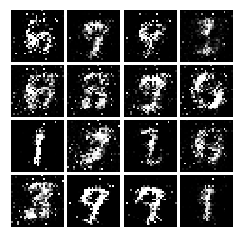


Iter: 1250, D: 1.157, G:1.655
Iter: 1300, D: 1.147, G:1.185
Iter: 1350, D: 1.26, G:0.9798
Iter: 1400, D: 1.208, G:1.237
Iter: 1450, D: 1.296, G:0.9707


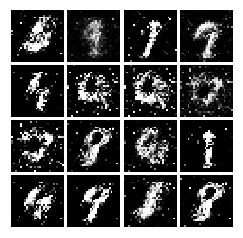


Iter: 1500, D: 1.213, G:0.8884
Iter: 1550, D: 1.205, G:0.9677
Iter: 1600, D: 1.261, G:1.08
Iter: 1650, D: 1.223, G:0.909
Iter: 1700, D: 1.203, G:0.9196


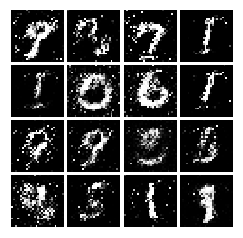


Iter: 1750, D: 1.366, G:0.9127
Iter: 1800, D: 1.417, G:1.379
Iter: 1850, D: 1.312, G:0.9108
Iter: 1900, D: 1.304, G:0.7238
Iter: 1950, D: 1.315, G:0.8158


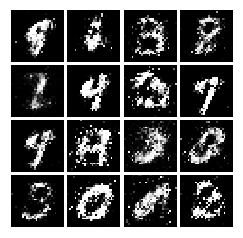


Iter: 2000, D: 1.367, G:0.8329
Iter: 2050, D: 1.272, G:0.9187
Iter: 2100, D: 1.334, G:0.8162
Iter: 2150, D: 1.287, G:0.8299
Iter: 2200, D: 1.267, G:0.8028


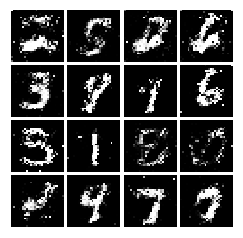


Iter: 2250, D: 1.335, G:0.8018
Iter: 2300, D: 1.319, G:0.832
Iter: 2350, D: 1.256, G:0.8816
Iter: 2400, D: 1.305, G:0.8481
Iter: 2450, D: 1.407, G:0.8565


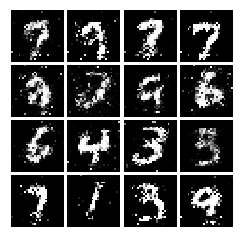


Iter: 2500, D: 1.275, G:0.9972
Iter: 2550, D: 1.286, G:0.9046
Iter: 2600, D: 1.413, G:0.8259
Iter: 2650, D: 1.332, G:0.9009
Iter: 2700, D: 1.279, G:0.9392


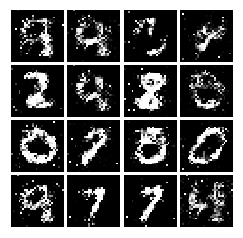


Iter: 2750, D: 1.303, G:0.8911
Iter: 2800, D: 1.264, G:0.8094
Iter: 2850, D: 1.296, G:0.7595
Iter: 2900, D: 1.248, G:0.8583
Iter: 2950, D: 1.311, G:0.8524


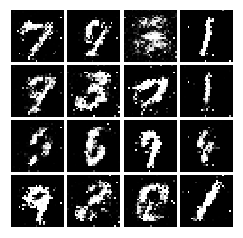


Iter: 3000, D: 1.288, G:0.9058
Iter: 3050, D: 1.311, G:0.8668
Iter: 3100, D: 1.342, G:0.8116
Iter: 3150, D: 1.365, G:0.824
Iter: 3200, D: 1.353, G:0.8234


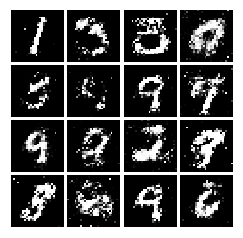


Iter: 3250, D: 1.334, G:0.9678
Iter: 3300, D: 1.306, G:0.8321
Iter: 3350, D: 1.39, G:0.8338
Iter: 3400, D: 1.348, G:0.8854
Iter: 3450, D: 1.371, G:0.8216


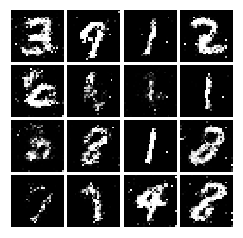


Iter: 3500, D: 1.325, G:0.8314
Iter: 3550, D: 1.34, G:0.819
Iter: 3600, D: 1.406, G:0.7509
Iter: 3650, D: 1.298, G:0.7993
Iter: 3700, D: 1.345, G:0.7405


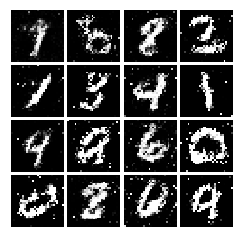


Iter: 3750, D: 1.372, G:0.8659
Iter: 3800, D: 1.329, G:0.683
Iter: 3850, D: 1.376, G:0.845
Iter: 3900, D: 1.39, G:0.7247
Iter: 3950, D: 1.338, G:0.7576


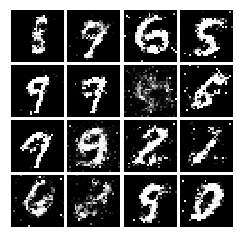


Iter: 4000, D: 1.357, G:0.8646
Iter: 4050, D: 1.319, G:0.7967
Iter: 4100, D: 1.327, G:0.8605
Iter: 4150, D: 1.432, G:0.821
Iter: 4200, D: 1.335, G:0.7913


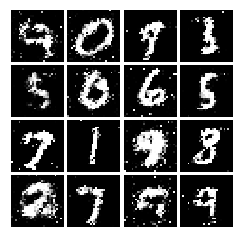


Iter: 4250, D: 1.268, G:0.7658
Final images


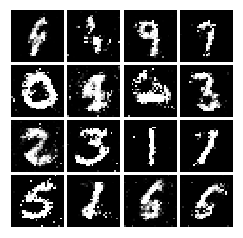

In [17]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [18]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1) ** 2)
    D_loss = 0.5 * tf.reduce_mean((score_real - 1) ** 2)    
    D_loss += 0.5 * tf.reduce_mean(score_fake ** 2)  
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [19]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [20]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

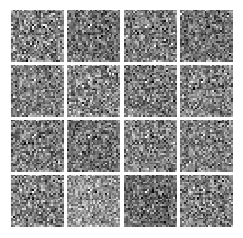


Iter: 0, D: 0.1446, G:0.4261
Iter: 50, D: 0.05988, G:1.009
Iter: 100, D: 0.0696, G:1.004
Iter: 150, D: 0.07551, G:0.5013
Iter: 200, D: 0.1477, G:0.4223


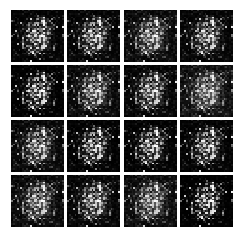


Iter: 250, D: 0.1262, G:0.245
Iter: 300, D: 0.09917, G:0.8821
Iter: 350, D: 0.06954, G:0.5111
Iter: 400, D: 0.1131, G:0.4886
Iter: 450, D: 0.1913, G:0.4023


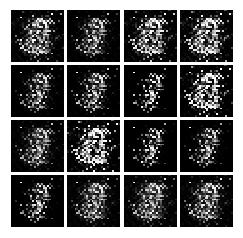


Iter: 500, D: 0.154, G:0.6235
Iter: 550, D: 0.2069, G:0.2605
Iter: 600, D: 0.1401, G:0.2539
Iter: 650, D: 0.1004, G:0.8953
Iter: 700, D: 0.8289, G:0.7381


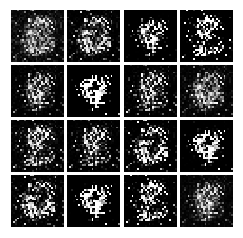


Iter: 750, D: 0.09434, G:0.888
Iter: 800, D: 0.1586, G:0.3122
Iter: 850, D: 0.1347, G:0.4811
Iter: 900, D: 0.3548, G:0.03416
Iter: 950, D: 0.1104, G:0.5275


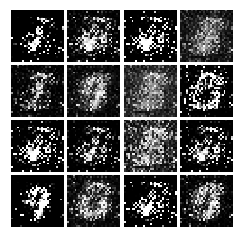


Iter: 1000, D: 0.4281, G:0.5245
Iter: 1050, D: 0.1224, G:0.2953
Iter: 1100, D: 0.1525, G:0.4311
Iter: 1150, D: 0.1643, G:0.09158
Iter: 1200, D: 0.1016, G:0.4245


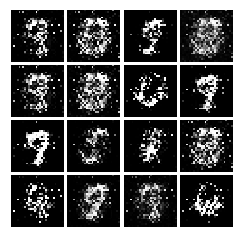


Iter: 1250, D: 0.1604, G:0.2334
Iter: 1300, D: 0.1592, G:0.3792
Iter: 1350, D: 0.1601, G:0.2869
Iter: 1400, D: 0.1536, G:0.262
Iter: 1450, D: 0.1695, G:0.2558


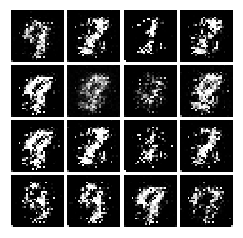


Iter: 1500, D: 0.1556, G:0.2587
Iter: 1550, D: 0.1263, G:0.3532
Iter: 1600, D: 0.1915, G:0.4398
Iter: 1650, D: 0.1793, G:0.2356
Iter: 1700, D: 0.1909, G:0.2268


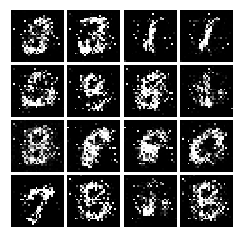


Iter: 1750, D: 0.2069, G:0.1878
Iter: 1800, D: 0.2061, G:0.2345
Iter: 1850, D: 0.1964, G:0.2328
Iter: 1900, D: 0.1812, G:0.247
Iter: 1950, D: 0.1842, G:0.2037


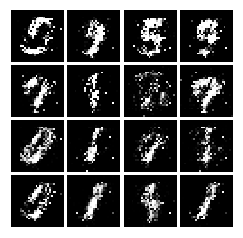


Iter: 2000, D: 0.1626, G:0.2968
Iter: 2050, D: 0.1781, G:0.3335
Iter: 2100, D: 0.1899, G:0.2853
Iter: 2150, D: 0.1912, G:0.2114
Iter: 2200, D: 0.1911, G:0.2268


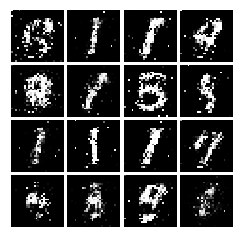


Iter: 2250, D: 0.2051, G:0.3682
Iter: 2300, D: 0.2161, G:0.1896
Iter: 2350, D: 0.2112, G:0.2053
Iter: 2400, D: 0.1885, G:0.2406
Iter: 2450, D: 0.2121, G:0.2705


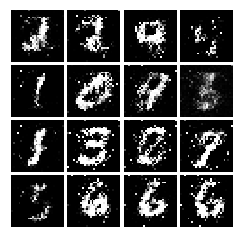


Iter: 2500, D: 0.2212, G:0.1565
Iter: 2550, D: 0.2257, G:0.183
Iter: 2600, D: 0.216, G:0.1808
Iter: 2650, D: 0.2597, G:0.1779
Iter: 2700, D: 0.227, G:0.1501



Iter: 2750, D: 0.1977, G:0.1846
Iter: 2800, D: 0.2297, G:0.1866
Iter: 2850, D: 0.2335, G:0.1892
Iter: 2900, D: 0.2046, G:0.2001
Iter: 2950, D: 0.2383, G:0.1737



Iter: 3000, D: 0.2403, G:0.1966
Iter: 3050, D: 0.2208, G:0.1717
Iter: 3100, D: 0.2067, G:0.1716
Iter: 3150, D: 0.2216, G:0.1632
Iter: 3200, D: 0.202, G:0.2087


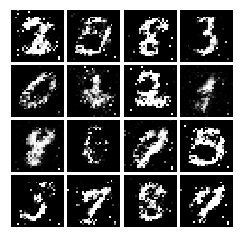


Iter: 3250, D: 0.218, G:0.1682
Iter: 3300, D: 0.2372, G:0.18
Iter: 3350, D: 0.216, G:0.1688
Iter: 3400, D: 0.2109, G:0.1732
Iter: 3450, D: 0.2137, G:0.187



Iter: 3500, D: 0.2446, G:0.1969
Iter: 3550, D: 0.2131, G:0.207
Iter: 3600, D: 0.2429, G:0.1669
Iter: 3650, D: 0.2187, G:0.1855
Iter: 3700, D: 0.2441, G:0.1693


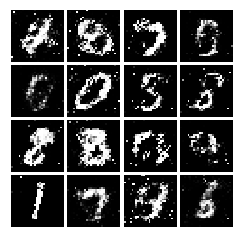


Iter: 3750, D: 0.2015, G:0.1934
Iter: 3800, D: 0.2116, G:0.1732
Iter: 3850, D: 0.2368, G:0.1775
Iter: 3900, D: 0.2306, G:0.1612
Iter: 3950, D: 0.2098, G:0.1839



Iter: 4000, D: 0.2165, G:0.2037
Iter: 4050, D: 0.2319, G:0.1703
Iter: 4100, D: 0.2278, G:0.1641
Iter: 4150, D: 0.241, G:0.1554
Iter: 4200, D: 0.2104, G:0.1821



Iter: 4250, D: 0.2217, G:0.1775
Final images


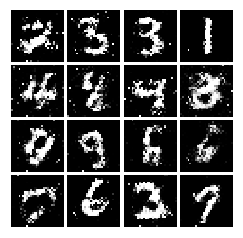

In [21]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

From blurry figures to more recognizable numbers, the differences between different numbers get larger along the training process.

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [22]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, filters=32, kernel_size=5, strides=1, activation=leaky_relu)
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        x = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=1, activation=leaky_relu)
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64, activation=leaky_relu)
        logits = tf.layers.dense(x, 1)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [23]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)
        z = tf.layers.dense(z, 7*7*128, activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)
        z = tf.reshape(z, [-1, 7, 7, 128])
        z = tf.layers.conv2d_transpose(z, 64, kernel_size=4, strides=2, padding='SAME', activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)        
        img = tf.layers.conv2d_transpose(z, 1, kernel_size=4, strides=2, padding='SAME', activation=tf.tanh)
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [24]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

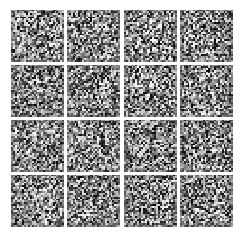


Iter: 0, D: 1.403, G:0.8404
Iter: 50, D: 0.3229, G:2.136
Iter: 100, D: 1.006, G:0.8148
Iter: 150, D: 2.043, G:3.044
Iter: 200, D: 0.8895, G:1.042


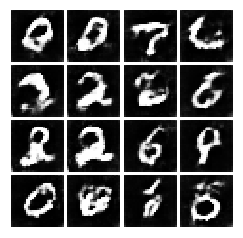


Iter: 250, D: 0.9711, G:1.022
Iter: 300, D: 1.092, G:1.323
Iter: 350, D: 0.9725, G:1.175
Iter: 400, D: 1.057, G:0.8882
Iter: 450, D: 1.085, G:0.8132


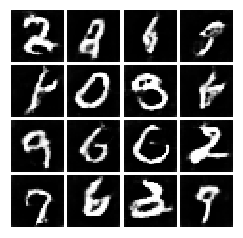


Iter: 500, D: 1.122, G:0.8847
Iter: 550, D: 1.122, G:1.575
Iter: 600, D: 1.126, G:0.9325
Iter: 650, D: 1.193, G:1.063
Iter: 700, D: 2.141, G:1.11


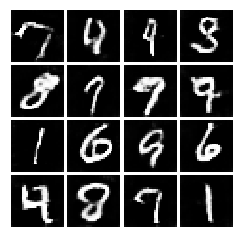


Iter: 750, D: 1.164, G:1.145
Iter: 800, D: 1.17, G:0.9873
Iter: 850, D: 1.114, G:0.9864
Iter: 900, D: 1.359, G:0.4523
Iter: 950, D: 1.141, G:0.7873



Iter: 1000, D: 1.189, G:1.065
Iter: 1050, D: 1.216, G:0.8936
Iter: 1100, D: 1.293, G:0.7472
Iter: 1150, D: 1.207, G:0.9789
Iter: 1200, D: 1.223, G:0.8133



Iter: 1250, D: 1.233, G:0.664
Iter: 1300, D: 1.094, G:1.034
Iter: 1350, D: 1.207, G:0.9128
Iter: 1400, D: 1.135, G:0.9307
Iter: 1450, D: 1.201, G:0.9359



Iter: 1500, D: 1.338, G:1.753
Iter: 1550, D: 1.126, G:0.9979
Iter: 1600, D: 1.094, G:0.913
Iter: 1650, D: 1.125, G:1.053
Iter: 1700, D: 1.222, G:1.694



Iter: 1750, D: 1.185, G:1.626
Iter: 1800, D: 1.173, G:0.8271
Iter: 1850, D: 1.123, G:1.023
Iter: 1900, D: 1.013, G:0.8557
Iter: 1950, D: 1.059, G:1.047


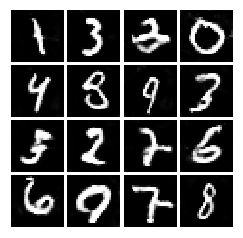


Iter: 2000, D: 1.138, G:1.109
Iter: 2050, D: 1.039, G:1.195
Iter: 2100, D: 1.184, G:0.9638
Final images


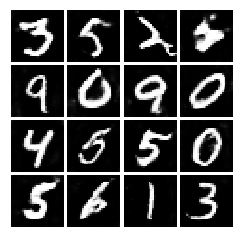

In [25]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

DCGAN can produce much clear figure compared to GAN's, which is far less noisy and have clear boundaries.

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [26]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, activation=leaky_relu)
        x = tf.layers.conv2d(x, filters=128, kernel_size=4, strides=2, activation=leaky_relu)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=leaky_relu)
        logits = tf.layers.dense(x, 1)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [27]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [31]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    G_loss = - tf.reduce_mean(logits_fake)
    # lambda from the paper
    lam = 10
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x + (1-eps) * tf.reshape(G_sample, [batch_size, -1])
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_grad_x_hat = tf.gradients(discriminator(x_hat), x_hat)[0]
        D_loss += lam * tf.reduce_mean(tf.pow(tf.norm(grad_grad_x_hat, axis=1) - 1, 2))
    return D_loss, G_loss


D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


Iter: 0, D: 17.2, G:-0.7825
Iter: 50, D: -3.236, G:-8.978
Iter: 100, D: -3.05, G:-2.141
Iter: 150, D: 0.4824, G:-0.2236
Iter: 200, D: -0.663, G:-2.879



Iter: 250, D: -0.1104, G:-0.3143
Iter: 300, D: -0.4027, G:2.941
Iter: 350, D: -0.3469, G:-0.3012
Iter: 400, D: 0.03815, G:-1.138
Iter: 450, D: -0.86, G:-0.1059



Iter: 500, D: -0.8602, G:-6.366
Iter: 550, D: -0.9032, G:-1.386
Iter: 600, D: -0.7657, G:-3.327
Iter: 650, D: -1.302, G:-1.255
Iter: 700, D: -1.413, G:1.59



Iter: 750, D: -0.5512, G:0.01634
Iter: 800, D: -2.116, G:-0.7206
Iter: 850, D: -2.304, G:-1.155
Iter: 900, D: -0.6251, G:-2.856
Iter: 950, D: -1.461, G:-6.023


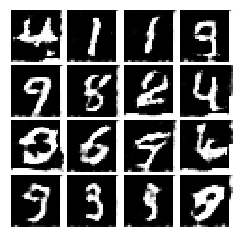


Iter: 1000, D: -2.144, G:3.867
Iter: 1050, D: -1.254, G:-5.889
Iter: 1100, D: -1.125, G:-4.576
Iter: 1150, D: 7.313, G:-4.92
Iter: 1200, D: -3.463, G:-5.917


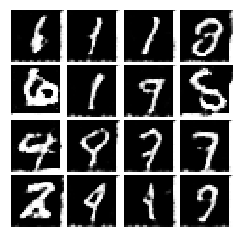


Iter: 1250, D: -3.872, G:-14.26
Iter: 1300, D: -1.076, G:-6.195
Iter: 1350, D: -2.508, G:-2.88
Iter: 1400, D: 0.2303, G:-1.577
Iter: 1450, D: 0.4627, G:-2.548


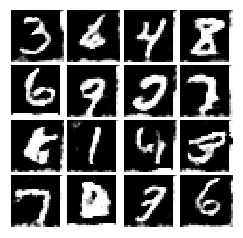


Iter: 1500, D: 0.08913, G:-1.564
Iter: 1550, D: -0.2565, G:0.1077
Iter: 1600, D: -0.5742, G:-2.54
Iter: 1650, D: -0.1316, G:1.149
Iter: 1700, D: -0.1145, G:0.1378


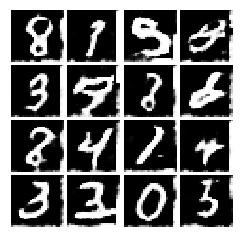


Iter: 1750, D: 0.2181, G:-0.1361
Iter: 1800, D: -0.1011, G:-6.897
Iter: 1850, D: -0.9576, G:-5.065
Iter: 1900, D: -1.694, G:-8.612
Iter: 1950, D: -1.661, G:-10.3


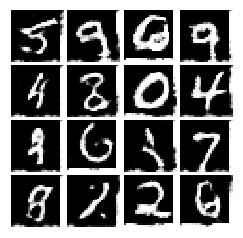


Iter: 2000, D: -1.506, G:-3.406
Iter: 2050, D: -0.585, G:-9.295
Iter: 2100, D: -1.299, G:-1.227
Final images


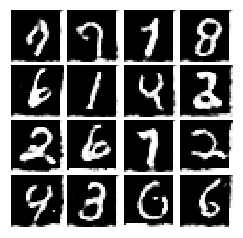

In [32]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)